In [225]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [226]:
master = pd.read_csv('./titanic/train.csv')

In [227]:
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [228]:
data = master[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


In [229]:
data = data.fillna(value = -1)

In [230]:
data = pd.concat([data,pd.get_dummies(data['Embarked'])],axis = 1).drop(columns = ['Embarked'])
data = pd.concat([data,pd.get_dummies(data['Sex'])],axis = 1).drop(columns = ['Sex'])

In [231]:
data

,Pclass,Age,SibSp,Parch,Fare,-1,C,Q,S,female,male
0,3,22.0,1,0,7.2500,0,0,0,1,0,1
1,1,38.0,1,0,71.2833,0,1,0,0,1,0
2,3,26.0,0,0,7.9250,0,0,0,1,1,0
3,1,35.0,1,0,53.1000,0,0,0,1,1,0
4,3,35.0,0,0,8.0500,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,0,0,0,1,0,1
887,1,19.0,0,0,30.0000,0,0,0,1,1,0
888,3,-1.0,1,2,23.4500,0,0,0,1,1,0
889,1,26.0,0,0,30.0000,0,1,0,0,0,1


In [232]:
d  = data.iloc[:,:].values
d[0]

array([ 3.  , 22.  ,  1.  ,  0.  ,  7.25,  0.  ,  0.  ,  0.  ,  1.  ,
        0.  ,  1.  ])

In [233]:
d_biased = np.c_[np.ones(len(d)),d]

In [234]:
d_biased

array([[ 1.,  3., 22., ...,  1.,  0.,  1.],
       [ 1.,  1., 38., ...,  0.,  1.,  0.],
       [ 1.,  3., 26., ...,  1.,  1.,  0.],
       ...,
       [ 1.,  3., -1., ...,  1.,  1.,  0.],
       [ 1.,  1., 26., ...,  0.,  0.,  1.],
       [ 1.,  3., 32., ...,  0.,  0.,  1.]])

In [235]:
truth = master['Survived'].values

# General ANN Structure

In [236]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam

In [237]:
def create_model(inputsize):
    model = Sequential()
    model.add(Dense(units = 256, input_dim = inputsize, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 0.01), metrics=['accuracy'])
    return model
              

In [238]:
def create_model_probability(inputsize):
    model = Sequential()
    model.add(Dense(units = 256, input_dim = inputsize, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 256, activation = 'relu'))
    model.add(Dense( units = 1, activation = 'softmax'))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.01), metrics=['accuracy'])
    return model
              

In [239]:
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_acc') > 0.8):   
            print("\nWe have reached %2.2f%% accuracy, so we will stopping training." %(logs.get('val_acc')*100))   
            self.model.stop_training = True

# Test Train Split

In [240]:
from sklearn.model_selection import train_test_split

In [241]:
X_train, X_test, y_train, y_test = train_test_split(d, truth, test_size=0.20, random_state=42)

In [242]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(d_biased, truth, test_size=0.20, random_state=42)

# Training

## Predict Yes or No

In [223]:
m1 = create_model(11)
callbacks = myCallback()
h1 = m1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 20,batch_size = 32,verbose = 2,callbacks=[callbacks])

Train on 712 samples, validate on 179 samples
Epoch 1/20
 - 2s - loss: 1.2593 - acc: 0.5534 - val_loss: 0.6339 - val_acc: 0.5866
Epoch 2/20
 - 0s - loss: 0.6339 - acc: 0.6404 - val_loss: 0.6425 - val_acc: 0.5866
Epoch 3/20
 - 0s - loss: 0.6142 - acc: 0.6250 - val_loss: 0.5894 - val_acc: 0.6201
Epoch 4/20
 - 0s - loss: 0.6208 - acc: 0.6559 - val_loss: 0.5848 - val_acc: 0.6034
Epoch 5/20
 - 0s - loss: 0.5996 - acc: 0.6770 - val_loss: 0.6389 - val_acc: 0.6257
Epoch 6/20
 - 0s - loss: 0.5703 - acc: 0.7051 - val_loss: 0.5243 - val_acc: 0.7486
Epoch 7/20
 - 0s - loss: 0.5684 - acc: 0.7612 - val_loss: 0.5434 - val_acc: 0.7654
Epoch 8/20
 - 0s - loss: 0.5617 - acc: 0.7317 - val_loss: 0.5015 - val_acc: 0.7765
Epoch 9/20
 - 0s - loss: 0.5113 - acc: 0.7556 - val_loss: 0.5305 - val_acc: 0.7598
Epoch 10/20
 - 0s - loss: 0.5397 - acc: 0.7626 - val_loss: 0.5423 - val_acc: 0.7598
Epoch 11/20

We have reached 80.45% accuracy, so we will stopping training.
 - 0s - loss: 0.5347 - acc: 0.7809 - val_loss: 

In [243]:
m2 = create_model(12)
callbacks = myCallback()
h2 = m2.fit(Xb_train,yb_train,validation_data=(Xb_test,yb_test),epochs = 20,batch_size = 32,verbose = 2,callbacks=[callbacks])

Train on 712 samples, validate on 179 samples
Epoch 1/20
 - 2s - loss: 1.3767 - acc: 0.5604 - val_loss: 0.6423 - val_acc: 0.6034
Epoch 2/20
 - 0s - loss: 0.6145 - acc: 0.6713 - val_loss: 0.5452 - val_acc: 0.6648
Epoch 3/20
 - 0s - loss: 0.6257 - acc: 0.6882 - val_loss: 0.6034 - val_acc: 0.6927
Epoch 4/20
 - 0s - loss: 0.5944 - acc: 0.6728 - val_loss: 0.5550 - val_acc: 0.7709
Epoch 5/20
 - 0s - loss: 0.5404 - acc: 0.7598 - val_loss: 0.5846 - val_acc: 0.7374
Epoch 6/20
 - 0s - loss: 0.5723 - acc: 0.7528 - val_loss: 0.4826 - val_acc: 0.7821
Epoch 7/20
 - 0s - loss: 0.5062 - acc: 0.7781 - val_loss: 0.5014 - val_acc: 0.7821
Epoch 8/20
 - 0s - loss: 0.5024 - acc: 0.7683 - val_loss: 0.5819 - val_acc: 0.5866
Epoch 9/20
 - 0s - loss: 0.5532 - acc: 0.7149 - val_loss: 0.5361 - val_acc: 0.7877
Epoch 10/20
 - 0s - loss: 0.4826 - acc: 0.8020 - val_loss: 0.7749 - val_acc: 0.7654
Epoch 11/20
 - 0s - loss: 0.5235 - acc: 0.8146 - val_loss: 0.5717 - val_acc: 0.7765
Epoch 12/20

We have reached 82.12% acc

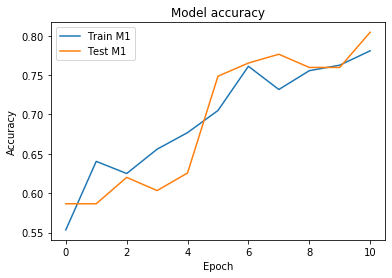

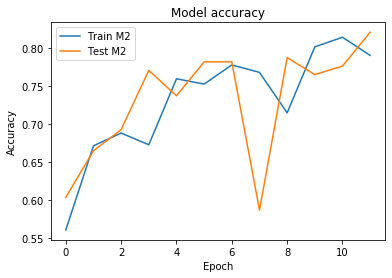

In [244]:
plt.plot(h1.history['acc'])
plt.plot(h1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train M1', 'Test M1'], loc='upper left')
plt.show()
plt.plot(h2.history['acc'])
plt.plot(h2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train M2', 'Test M2'], loc='upper left')
plt.show()


## Predict Probability of Yes

In [245]:
m3 = create_model_probability(11)
h3 = m3.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 20,batch_size = 32,verbose = 2)

Train on 712 samples, validate on 179 samples
Epoch 1/20
 - 2s - loss: 0.6236 - acc: 0.3764 - val_loss: 0.5866 - val_acc: 0.4134
Epoch 2/20
 - 0s - loss: 0.6236 - acc: 0.3764 - val_loss: 0.5866 - val_acc: 0.4134
Epoch 3/20
 - 0s - loss: 0.6236 - acc: 0.3764 - val_loss: 0.5866 - val_acc: 0.4134
Epoch 4/20
 - 0s - loss: 0.6236 - acc: 0.3764 - val_loss: 0.5866 - val_acc: 0.4134
Epoch 5/20
 - 0s - loss: 0.6236 - acc: 0.3764 - val_loss: 0.5866 - val_acc: 0.4134
Epoch 6/20
 - 0s - loss: 0.6236 - acc: 0.3764 - val_loss: 0.5866 - val_acc: 0.4134
Epoch 7/20
 - 0s - loss: 0.6236 - acc: 0.3764 - val_loss: 0.5866 - val_acc: 0.4134
Epoch 8/20
 - 0s - loss: 0.6236 - acc: 0.3764 - val_loss: 0.5866 - val_acc: 0.4134
Epoch 9/20
 - 0s - loss: 0.6236 - acc: 0.3764 - val_loss: 0.5866 - val_acc: 0.4134
Epoch 10/20
 - 0s - loss: 0.6236 - acc: 0.3764 - val_loss: 0.5866 - val_acc: 0.4134
Epoch 11/20
 - 0s - loss: 0.6236 - acc: 0.3764 - val_loss: 0.5866 - val_acc: 0.4134
Epoch 12/20
 - 0s - loss: 0.6236 - acc: